In [1]:
import os
import multiprocessing
import time
import numpy as np
from einsumt import einsumt as einsum
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Parameter
from qiskit import Aer, execute
from numpy.random import default_rng
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import numba

@numba.vectorize([numba.float64(numba.complex128), numba.float32(numba.complex64)], target='parallel')
def abs2(x):
    return x.real**2 + x.imag**2

In [3]:
def one_step(dt, m=0.5, w=1., J=1., barrier=False):
    num_sites = system_size
    
    qc = QuantumCircuit(num_sites)
    
    # exp(-i dt Hzz)
    for iqr in range(1, num_sites - 1):
        phi = J * 0.5 * (2. * dt) * (num_sites - iqr - 1)
        for iql in range(iqr):
            qc.cx(iql, iqr)
            qc.p(phi, iqr)
            qc.cx(iql, iqr)
            
    if barrier:
        qc.barrier()
            
    # exp(-i dt Hpm)
    # Hpm = w sum (sigma+ sigma- + h.c.) = w sum h
    # h = 1/2 XX + 1/2 YY
    phi = w * 0.5 * (2. * dt)
    for iq in range(num_sites - 1):
        # exp(-i dt w/2 XX)
        qc.cx(iq, iq + 1)
        qc.rx(phi, iq)
        qc.cx(iq, iq + 1)
        # exp(-i dt w/2 YY)
        qc.cz(iq, iq + 1)
        qc.cx(iq, iq + 1)
        qc.rx(phi, iq)
        qc.cx(iq, iq + 1)
        qc.cz(iq, iq + 1)
        
    if barrier:
        qc.barrier()

    # exp(-i dt Hz1)
    phi = m * 0.5 * (2. * dt)
    for iq in range(num_sites):
        if iq % 2 == 0:
            qc.p(-phi, iq)
        else:
            qc.p(phi, iq)
            
    if barrier:
        qc.barrier()

    # exp(-i dt Hz2)
    for iq in range(num_sites - 1):
        phi = -J * 0.5 * (num_sites // 2 - (iq + 1) // 2) * (2. * dt)
        qc.p(phi, iq)
            
    if barrier:
        qc.barrier()
            
    return qc

In [4]:
def get_renyi_entropy_swaptest(circuit, subsystem):
    nq = circuit.num_qubits
    circ = QuantumCircuit(nq * 2 + 1, 1)
    circ = circ.compose(circuit, qubits=list(range(nq)))
    circ = circ.compose(circuit, qubits=list(range(nq, nq * 2)))

    # cswap only on the subsystem
    circ.h(nq * 2)
    for iq in subsystem:
        circ.cswap(nq * 2, iq, nq + iq)
    circ.h(nq * 2)
    circ.measure(nq * 2, 0)
    
    backend = Aer.get_backend('qasm_simulator')
    backend.set_options(method='statevector_gpu')
    shots = 2 ** 19
    job = execute(circ, backend, shots=shots)
    result = job.result()
    print(result.data(0)['counts'])
    zero_counts = result.data(0)['counts']['0x0']
    
    return zero_counts / shots * 2. - 1.

In [5]:
def get_renyi_entropy(statevector, subsystem):
    #system_size = int(np.log2(statevector.shape[0]))
    subsystem_size = len(subsystem)
    
    start = time.time()
        
    # assuming subsystem is contiguous
    low = min(subsystem)
    high = system_size - max(subsystem) - 1
    statevector = statevector.reshape([2 ** high, 2 ** subsystem_size, 2 ** low])

    treshape = time.time() - start

    # p_i p_j |<psi_i | psi_j>|^2
    # statevector components are unnormalized -> square(abs(statevector)) = p_i ||psi_i>|^2
    #purity = np.sum(np.square(np.abs(np.einsum('ik,jk->ij', np.conjugate(statevector), statevector)))) # by environment indices
    #purity = np.sum(np.square(np.abs(np.einsum('ij,ik->jk', np.conjugate(statevector), statevector)))) # by subsystem indices
    #purity = np.sum(abs2(einsum('ik,jk->ij', np.conjugate(statevector), statevector))) # by environment indices
    start = time.time()
    conj = np.conjugate(statevector)
    tconj = time.time() - start
    print(statevector.shape)
    start = time.time()
    #prod = np.matmul(conj.T, statevector)
    prod = np.tensordot(conj, statevector, axes=([0, 2], [0, 2]))
    #raise RuntimeError(prod)
    tprod = time.time() - start
    conj = None
    start = time.time()
    prob = abs2(prod)
    tprob = time.time() - start
    prod = None
    start = time.time()
    purity = np.sum(prob)
    tpurity = time.time() - start
    start = time.time()
    entropy = -np.log2(purity)
    tentropy = time.time() - start
    print('reshape', treshape, 'conj', tconj, 'prod', tprod, 'prob', tprob, 'purity', tpurity, 'entropy', tentropy)
    #purity = np.sum(abs2(np.matmul(np.conjugate(statevector), statevector.T)))
    
    # einsum is not parallelized
#    conj = np.conjugate(statevector)
#    outerprod = np.tensordot(conj, statevector, axes=([1], [1]))
#    purity = np.sum(abs2(outerprod))
    
    return -np.log2(purity)

In [6]:
# try:
#     os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda/lib64'
# except KeyError:
#     os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64'

MAX_SIZE = 30

@tf.function
def compute_purity_tf(statevector_real, statevector_imag, shape):
    statevector_real = tf.reshape(statevector_real, shape)
    statevector_imag = tf.reshape(statevector_imag, shape)
    
    prod_real = tf.tensordot(statevector_real, statevector_real, axes=[[0, 2], [0, 2]])
    prod_real += tf.tensordot(statevector_imag, statevector_imag, axes=[[0, 2], [0, 2]])
    prod_imag = tf.tensordot(statevector_real, statevector_imag, axes=[[0, 2], [0, 2]])
    prod_imag -= tf.tensordot(statevector_imag, statevector_real, axes=[[0, 2], [0, 2]])
    purity = tf.tensordot(prod_real, prod_real, axes=[[0, 1], [0, 1]])
    purity += tf.tensordot(prod_imag, prod_imag, axes=[[0, 1], [0, 1]])
    
    return purity

def get_renyi_entropy_tf(statevector, subsystem):
    subsystem_size = len(subsystem)

    if system_size <= MAX_SIZE:
        low = min(subsystem)
        high = system_size - max(subsystem) - 1
        shape = tf.constant([2 ** high, 2 ** subsystem_size, 2 ** low])

        slices = [np.s_[:]]
    elif max(subsystem) < MAX_SIZE:
        low = min(subsystem)
        high = MAX_SIZE - max(subsystem) - 1
        shape = tf.constant([2 ** high, 2 ** subsystem_size, 2 ** low])

        block_size = 2 ** MAX_SIZE
        slices = [np.s_[block_size * i:block_size * (i + 1)] for i in range(2 ** (system_size - MAX_SIZE))]
    else:
        raise RuntimeError('don\'t do this it\'s too much work')

    purity = 0.
    for sl in slices:
        purity += compute_purity_tf(tf.constant(statevector.real[sl]), tf.constant(statevector.imag[sl]), shape).numpy()
    entropy = -np.log2(purity)

    return entropy

In [7]:
def get_subsystem_probs(circuit):
#     backend = Aer.get_backend('statevector_simulator')
#     job = execute(circuit, backend)
#     result = job.result()
#     probs = np.square(np.abs(result.data()['statevector']))
    
    backend = Aer.get_backend('qasm_simulator')
    backend.set_options(method='statevector_gpu')
    circuit.measure_all()
    shots = 2 ** 16
    job = execute(circuit, backend, shots=2**16)
    result = job.result()
    
    probs = np.zeros(2 ** system_size, dtype=np.float)
    for hexidx, count in result.data(0)['counts'].items():
        probs[int(hexidx[:(system_size // 4) + 2], 16)] = count
    probs /= shots
        
    # take the subsystem from the center of the bitstring
    margin = 2 ** ((system_size - subsystem_size) // 2)
    probs = np.sum(probs.reshape((margin, 2 ** subsystem_size, margin)), axis=(0, 2))
    
    return probs

In [8]:
def get_electron_number_distribution(probs):
    result = np.zeros(subsystem_size + 1, dtype=np.float)
    for idx, prob in enumerate(probs):
        # up to subsystem_size == 8
        bitarray = np.unpackbits(np.array(idx, dtype=np.uint8))[-1:-subsystem_size - 1:-1]
        z = np.sum(1 - bitarray[0::2], dtype=np.int) - np.sum(bitarray[1::2], dtype=np.int) + (subsystem_size // 2)
        result[z] += prob
        
    return result

In [9]:
system_size = 28
subsystem = list(range(11, 19))
subsystem_size = len(subsystem)

m = 0.5
w = 1.
J = 1.

In [10]:
dt = np.pi / 16.
num_steps = 20

In [11]:
entropies = np.empty(num_steps + 1, dtype=np.float)
entropies[0] = 0.

circuit = QuantumCircuit(system_size)

# initial state = vacuum
for iq in range(0, system_size, 2):
    circuit.x(iq)

for istep in range(num_steps):
    start = time.time()
    circuit += one_step(dt)
    
    backend = Aer.get_backend('statevector_simulator')
    backend.set_options(method='statevector_gpu')
    job = execute(circuit, backend)
    result = job.result()
    statevector = result.data()['statevector']
    
    print(time.time() - start, 's to move one step')

    start = time.time()
    entropy = get_renyi_entropy(statevector, subsystem)
    entropies[istep + 1] = entropy
    print(time.time() - start, 's to compute the entropy')

In [12]:
for istep in range(num_steps):
    circuit += one_step(dt)
    if istep != num_steps - 1:
        circuit.snapshot('step{}'.format(istep))

start = time.time()
backend = Aer.get_backend('statevector_simulator')
backend.set_options(method='statevector_gpu')
job = execute(circuit, backend)
data = job.result().data()
print(time.time() - start, 's to compute the statevectors')

108.43498086929321 s to compute the statevectors


In [13]:
statevectors = [data['snapshots']['statevector']['step{}'.format(istep)][0] for istep in range(num_steps - 1)]
statevectors.append(data['statevector'])

for istep, statevector in enumerate(statevectors):
    start = time.time()
    entropy = get_renyi_entropy_tf(statevector, subsystem)
    entropies[istep + 1] = entropy
    print(time.time() - start, 's to compute the entropy')

7.696946620941162 s to compute the entropy
5.266624689102173 s to compute the entropy
5.252077102661133 s to compute the entropy
5.23181676864624 s to compute the entropy
5.2199547290802 s to compute the entropy
5.207066774368286 s to compute the entropy
5.32854437828064 s to compute the entropy
5.3251953125 s to compute the entropy
5.327316999435425 s to compute the entropy
5.3534369468688965 s to compute the entropy
5.283183813095093 s to compute the entropy
5.235624074935913 s to compute the entropy
5.2737438678741455 s to compute the entropy
5.276337146759033 s to compute the entropy
5.246612548828125 s to compute the entropy
5.248380184173584 s to compute the entropy
5.268268823623657 s to compute the entropy
5.2594428062438965 s to compute the entropy
5.256901741027832 s to compute the entropy
5.271021127700806 s to compute the entropy


(4194304, 256)
conj 4.3823323249816895 prod 88.82510685920715 prob 0.00017189979553222656 purity 0.00012040138244628906
102.49019455909729 s to compute the entropy
(4194304, 256)
conj 4.1126720905303955 prod 11.836031675338745 prob 0.000141143798828125 purity 0.00011515617370605469
24.874769926071167 s to compute the entropy
(4194304, 256)
conj 4.122253656387329 prod 14.296188592910767 prob 0.00014519691467285156 purity 0.000118255615234375
27.454813718795776 s to compute the entropy
(4194304, 256)
conj 4.260644435882568 prod 13.633363485336304 prob 0.0001480579376220703 purity 0.0001227855682373047
27.13946557044983 s to compute the entropy
(4194304, 256)
conj 4.161118030548096 prod 15.46696400642395 prob 0.00014495849609375 purity 0.00011396408081054688
28.771482706069946 s to compute the entropy
(4194304, 256)
conj 4.131652116775513 prod 13.794524908065796 prob 0.0001430511474609375 purity 0.00011396408081054688
27.037447452545166 s to compute the entropy
(4194304, 256)
conj 4.1322996616363525 prod 13.098738431930542 prob 0.00014019012451171875 purity 0.00011086463928222656
26.27515149116516 s to compute the entropy
(4194304, 256)
conj 4.092943429946899 prod 12.78951621055603 prob 0.00014090538024902344 purity 0.00011277198791503906
25.930195808410645 s to compute the entropy
(4194304, 256)
conj 4.2148401737213135 prod 13.531028747558594 prob 0.00015115737915039062 purity 0.00011396408081054688
26.879091262817383 s to compute the entropy
(4194304, 256)
conj 4.336042881011963 prod 18.468639135360718 prob 0.00017786026000976562 purity 0.00011706352233886719
32.21967649459839 s to compute the entropy
plt.plot(np.arange(num_steps + 1), entropies / subsystem

(8192, 256, 512)
reshape 2.384185791015625e-05 conj 4.262945890426636 prod 89.08509635925293 prob 0.0003581047058105469 purity 0.0001227855682373047 entropy 2.0742416381835938e-05
93.38376212120056 s to compute the entropy
(8192, 256, 512)
reshape 1.2874603271484375e-05 conj 4.360467433929443 prod 26.1311252117157 prob 0.000156402587890625 purity 0.00011157989501953125 entropy 1.7404556274414062e-05
30.528235912322998 s to compute the entropy
(8192, 256, 512)
reshape 8.106231689453125e-06 conj 4.356942415237427 prod 26.82246732711792 prob 0.00014901161193847656 purity 0.00010704994201660156 entropy 1.7404556274414062e-05
31.217225313186646 s to compute the entropy

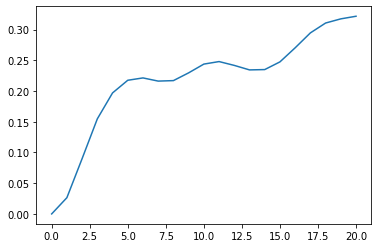

In [14]:
plt.plot(np.arange(num_steps + 1), entropies / subsystem_size)

In [15]:
low = min(subsystem)
high = system_size - max(subsystem) - 1
statevector = statevector.reshape([2 ** high, 2 ** subsystem_size, 2 ** low])

probs = np.sum(abs2(statevector), axis=(0, 2))
indices = np.arange(2 ** subsystem_size, dtype=np.uint8).reshape((-1, 1))
bitarray = np.unpackbits(indices, axis=1)
electron_numbers = np.sum(1 - bitarray[:, 0::2], axis=1, dtype=np.int) - np.sum(bitarray[:, 1::2], axis=1, dtype=np.int)

dist = np.zeros(subsystem_size + 1)
for n in range(-subsystem_size // 2, subsystem_size // 2 + 1):
    idx = np.nonzero(electron_numbers == n)[0]
    dist[n + subsystem_size // 2] += np.sum(probs[idx])

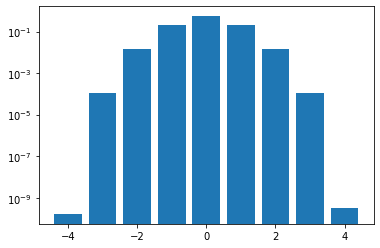

In [16]:
plt.bar(np.linspace(-(subsystem_size // 2), subsystem_size // 2, subsystem_size + 1), dist)
plt.yscale('log')